## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.
C:\Users\MCUT\anaconda3\envs\class\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\MCUT\anaconda3\envs\class\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\MCUT\anaconda3\envs\class\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\MCUT\anaconda3\envs\class\lib\site-packag

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [9]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS =  25 # IF you feel too long to finish, try to make it smaller
BATCH_SIZE = 1024

In [10]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.1, 0.5, 0.9]
redice_lr_patient = [1, 5, 9]

In [11]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.10, reduce_patient: 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_67 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_68 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 2s 31us/step - loss: 3.0987 - acc: 0.0927 - val_loss: 3.1135 - val_acc: 0.0889
Epoch 10/25
50000/50000 [==============================] - 2s 31us/step - loss: 3.1001 - acc: 0.0927 - val_loss: 3.1136 - val_acc: 0.0888
Epoch 11/25
50000/50000 [==============================] - 2s 31us/step - loss: 3.0993 - acc: 0.0926 - val_loss: 3.1139 - val_acc: 0.0886

Epoch 00011: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.
Epoch 12/25
50000/50000 [==============================] - 2s 31us/step - loss: 3.0988 - acc: 0.0929 - val_loss: 3.1139 - val_acc: 0.0885
Epoch 13/25
50000/50000 [==============================] - 2s 31us/step - loss: 3.0987 - acc: 0.0926 - val_loss: 3.1137 - val_acc: 0.0888
Epoch 14/25
50000/50000 [==============================] - 2s 31us/step - loss: 3.0983 - acc: 0.0927 - val_loss: 3.1135 - val_acc: 0.0885
Epoch 15/25
50000/50000 [==============================] - 2s 31us/step - loss: 3.0999 - acc: 0.0921 - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 95us/step - loss: 3.2186 - acc: 0.0774 - val_loss: 3.2544 - val_acc: 0.0772
Epoch 2/25
50000/50000 [==============================] - 1s 30us/step - loss: 3.2173 - acc: 0.0782 - val_loss: 3.2546 - val_acc: 0.0771
Epoch 3/25
50000/50000 [==============================] - 1s 30us/step - loss: 3.2181 - acc: 0.0778 - val_loss: 3.2542 - val_acc: 0.0771
Epoch 4/25
50000/50000 [==============================] - 1s 30us/step - loss: 3.2180 - acc: 0.0786 - val_loss: 3.2538 - val_acc: 0.0771
Epoch 5/25
50000/50000 [==============================] - 1s 30us/step - loss: 3.2186 - acc: 0.0782 - val_loss: 3.2538 - val_acc: 0.0771
Epoch 6/25
50000/50000 [==============================] - 2s 30us/step - loss: 3.2182 - acc: 0.0784 - val_loss: 3.2539 - val_acc: 0.0771
Epoch 7/25
50000/50000 [==============================] - 2s 30us/step - loss: 3.2191 - acc: 0.0778 - val_loss: 3.2540 - val_acc

50000/50000 [==============================] - 2s 31us/step - loss: 3.0092 - acc: 0.0975 - val_loss: 2.9942 - val_acc: 0.0985
Epoch 25/25
50000/50000 [==============================] - 2s 32us/step - loss: 3.0091 - acc: 0.0983 - val_loss: 2.9942 - val_acc: 0.0984
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 9
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_82 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalizatio

Epoch 12/25
50000/50000 [==============================] - 1s 30us/step - loss: 2.8931 - acc: 0.1146 - val_loss: 2.8680 - val_acc: 0.1156
Epoch 13/25
50000/50000 [==============================] - 2s 30us/step - loss: 2.8921 - acc: 0.1153 - val_loss: 2.8682 - val_acc: 0.1154
Epoch 14/25
50000/50000 [==============================] - 1s 30us/step - loss: 2.8922 - acc: 0.1146 - val_loss: 2.8680 - val_acc: 0.1158
Epoch 15/25
50000/50000 [==============================] - 2s 30us/step - loss: 2.8917 - acc: 0.1155 - val_loss: 2.8681 - val_acc: 0.1155
Epoch 16/25
50000/50000 [==============================] - 1s 29us/step - loss: 2.8927 - acc: 0.1148 - val_loss: 2.8680 - val_acc: 0.1156
Epoch 17/25
50000/50000 [==============================] - 2s 31us/step - loss: 2.8918 - acc: 0.1145 - val_loss: 2.8678 - val_acc: 0.1156
Epoch 18/25
50000/50000 [==============================] - 2s 31us/step - loss: 2.8919 - acc: 0.1149 - val_loss: 2.8678 - val_acc: 0.1157
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 103us/step - loss: 3.0242 - acc: 0.1012 - val_loss: 3.0102 - val_acc: 0.1026
Epoch 2/25
50000/50000 [==============================] - 1s 30us/step - loss: 3.0253 - acc: 0.1002 - val_loss: 3.0104 - val_acc: 0.1025
Epoch 3/25
50000/50000 [==============================] - 2s 30us/step - loss: 3.0249 - acc: 0.1017 - val_loss: 3.0105 - val_acc: 0.1024
Epoch 4/25
50000/50000 [==============================] - 2s 31us/step - loss: 3.0248 - acc: 0.1013 - val_loss: 3.0105 - val_acc: 0.1024
Epoch 5/25
50000/50000 [==============================] - 1s 30us/step - loss: 3.0253 - acc: 0.1007 - val_loss: 3.0104 - val_acc: 0.1024
Epoch 6/25
50000/50000 [==============================] - 2s 30us/step - loss: 3.0244 - acc: 0.1009 - val_loss: 3.0103 - val_acc: 0.1024
Epoch 7/25
50000/50000 [==============================] - 2s 31us/step - loss: 3.0243 - acc: 0.1014 - val_loss: 3.0101 - val_ac

50000/50000 [==============================] - 2s 34us/step - loss: 1.2457 - acc: 0.5662 - val_loss: 1.3932 - val_acc: 0.5149

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.
Epoch 21/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.2460 - acc: 0.5673 - val_loss: 1.3932 - val_acc: 0.5145

Epoch 00021: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-12.
Epoch 22/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.2454 - acc: 0.5659 - val_loss: 1.3932 - val_acc: 0.5144

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1e-12.
Epoch 23/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.2451 - acc: 0.5663 - val_loss: 1.3933 - val_acc: 0.5147
Epoch 24/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.2453 - acc: 0.5664 - val_loss: 1.3932 - val_acc: 0.5144
Epoch 25/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.2452 - acc: 0

50000/50000 [==============================] - 2s 31us/step - loss: 2.9256 - acc: 0.1095 - val_loss: 2.9391 - val_acc: 0.1060
Epoch 7/25
50000/50000 [==============================] - 2s 30us/step - loss: 2.9241 - acc: 0.1093 - val_loss: 2.9392 - val_acc: 0.1059
Epoch 8/25
50000/50000 [==============================] - 2s 31us/step - loss: 2.9245 - acc: 0.1095 - val_loss: 2.9393 - val_acc: 0.1061
Epoch 9/25
50000/50000 [==============================] - 2s 30us/step - loss: 2.9248 - acc: 0.1098 - val_loss: 2.9392 - val_acc: 0.1059
Epoch 10/25
50000/50000 [==============================] - 2s 31us/step - loss: 2.9234 - acc: 0.1103 - val_loss: 2.9394 - val_acc: 0.1060
Epoch 11/25
50000/50000 [==============================] - 2s 31us/step - loss: 2.9238 - acc: 0.1094 - val_loss: 2.9396 - val_acc: 0.1060
Epoch 12/25
50000/50000 [==============================] - 2s 31us/step - loss: 2.9262 - acc: 0.1097 - val_loss: 2.9395 - val_acc: 0.1062
Epoch 13/25
50000/50000 [========================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 123us/step - loss: 3.0876 - acc: 0.0900 - val_loss: 3.0737 - val_acc: 0.0911
Epoch 2/25
50000/50000 [==============================] - 2s 32us/step - loss: 3.0874 - acc: 0.0900 - val_loss: 3.0733 - val_acc: 0.0910
Epoch 3/25
50000/50000 [==============================] - 2s 32us/step - loss: 3.0873 - acc: 0.0894 - val_loss: 3.0733 - val_acc: 0.0910
Epoch 4/25
50000/50000 [==============================] - 2s 32us/step - loss: 3.0877 - acc: 0.0898 - val_loss: 3.0735 - val_acc: 0.0910
Epoch 5/25
50000/50000 [==============================] - 2s 32us/step - loss: 3.0878 - acc: 0.0899 - val_loss: 3.0732 - val_acc: 0.0910
Epoch 6/25
50000/50000 [==============================] - 2s 32us/step - loss: 3.0863 - acc: 0.0896 - val_loss: 3.0732 - val_acc: 0.0912
Epoch 7/25
50000/50000 [==============================] - 2s 32us/step - loss: 3.0877 - acc: 0.0892 - val_loss: 3.0733 - val_ac

50000/50000 [==============================] - 2s 31us/step - loss: 3.0263 - acc: 0.0998 - val_loss: 3.0023 - val_acc: 0.1035
Epoch 25/25
50000/50000 [==============================] - 2s 31us/step - loss: 3.0269 - acc: 0.1003 - val_loss: 3.0023 - val_acc: 0.1034
Numbers of exp: 15, reduce_factor: 0.90, reduce_patient: 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_112 (Bat (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 2s 32us/step - loss: 3.0592 - acc: 0.1057 - val_loss: 3.0530 - val_acc: 0.1048
Epoch 13/25
50000/50000 [==============================] - 2s 32us/step - loss: 3.0602 - acc: 0.1051 - val_loss: 3.0527 - val_acc: 0.1046
Epoch 14/25
50000/50000 [==============================] - 2s 33us/step - loss: 3.0597 - acc: 0.1048 - val_loss: 3.0528 - val_acc: 0.1048
Epoch 15/25
50000/50000 [==============================] - 2s 32us/step - loss: 3.0581 - acc: 0.1057 - val_loss: 3.0526 - val_acc: 0.1045
Epoch 16/25
50000/50000 [==============================] - 2s 32us/step - loss: 3.0595 - acc: 0.1049 - val_loss: 3.0527 - val_acc: 0.1045
Epoch 17/25
50000/50000 [==============================] - 2s 33us/step - loss: 3.0600 - acc: 0.1045 - val_loss: 3.0528 - val_acc: 0.1044
Epoch 18/25
50000/50000 [==============================] - 2s 31us/step - loss: 3.0595 - acc: 0.1053 - val_loss: 3.0528 - val_acc: 0.1046
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.8156 - acc: 0.3722 - val_loss: 2.0667 - val_acc: 0.3170
Epoch 2/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.5404 - acc: 0.4582 - val_loss: 2.0678 - val_acc: 0.3124

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 3/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.3595 - acc: 0.5251 - val_loss: 1.7092 - val_acc: 0.3978
Epoch 4/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.3080 - acc: 0.5450 - val_loss: 1.6197 - val_acc: 0.4260
Epoch 5/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.2785 - acc: 0.5550 - val_loss: 1.5462 - val_acc: 0.4525
Epoch 6/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.2509 - acc: 0.5660 - val_loss: 1.5606 - val_acc: 0.4491

Epoch 00006: ReduceLROnPlateau reducing lear

Epoch 23/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.4260 - acc: 0.5060 - val_loss: 1.6042 - val_acc: 0.4467
Epoch 24/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.4135 - acc: 0.5115 - val_loss: 1.5963 - val_acc: 0.4523
Epoch 25/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.4019 - acc: 0.5145 - val_loss: 1.5942 - val_acc: 0.4506
Numbers of exp: 20, reduce_factor: 0.10, reduce_patient: 9
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_127 (Bat (None, 512)               2048      
_________________________________________________________________

50000/50000 [==============================] - 2s 31us/step - loss: 1.6323 - acc: 0.4334 - val_loss: 1.7364 - val_acc: 0.4014
Epoch 11/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.6073 - acc: 0.4418 - val_loss: 1.7184 - val_acc: 0.4080
Epoch 12/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.5850 - acc: 0.4487 - val_loss: 1.7035 - val_acc: 0.4115
Epoch 13/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.5646 - acc: 0.4575 - val_loss: 1.6852 - val_acc: 0.4162
Epoch 14/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.5465 - acc: 0.4625 - val_loss: 1.6764 - val_acc: 0.4196
Epoch 15/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.5268 - acc: 0.4695 - val_loss: 1.6624 - val_acc: 0.4242
Epoch 16/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.5111 - acc: 0.4759 - val_loss: 1.6543 - val_acc: 0.4272
Epoch 17/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 157us/step - loss: 2.5250 - acc: 0.1853 - val_loss: 2.4511 - val_acc: 0.2359
Epoch 2/25
50000/50000 [==============================] - 2s 33us/step - loss: 2.1612 - acc: 0.2733 - val_loss: 2.2085 - val_acc: 0.2759
Epoch 3/25
50000/50000 [==============================] - 2s 32us/step - loss: 2.0038 - acc: 0.3148 - val_loss: 2.0779 - val_acc: 0.3115
Epoch 4/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.9047 - acc: 0.3439 - val_loss: 1.9776 - val_acc: 0.3318
Epoch 5/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.8339 - acc: 0.3678 - val_loss: 1.9258 - val_acc: 0.3478
Epoch 6/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.7785 - acc: 0.3828 - val_loss: 1.8711 - val_acc: 0.3586
Epoch 7/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.7353 - acc: 0.3981 - val_loss: 1.8276 - val_ac

50000/50000 [==============================] - 2s 31us/step - loss: 1.4037 - acc: 0.5157 - val_loss: 1.6052 - val_acc: 0.4441
Epoch 25/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.3925 - acc: 0.5180 - val_loss: 1.6013 - val_acc: 0.4451
Numbers of exp: 25, reduce_factor: 0.90, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_142 (Bat (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.6008 - acc: 0.4410 - val_loss: 1.6929 - val_acc: 0.4138
Epoch 13/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.5795 - acc: 0.4506 - val_loss: 1.6779 - val_acc: 0.4216
Epoch 14/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.5596 - acc: 0.4556 - val_loss: 1.6697 - val_acc: 0.4253
Epoch 15/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.5406 - acc: 0.4630 - val_loss: 1.6554 - val_acc: 0.4301
Epoch 16/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.5233 - acc: 0.4703 - val_loss: 1.6483 - val_acc: 0.4313
Epoch 17/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.5075 - acc: 0.4761 - val_loss: 1.6376 - val_acc: 0.4343
Epoch 18/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.4922 - acc: 0.4812 - val_loss: 1.6275 - val_acc: 0.4391
Epoch 19/25
50000/50000 [=========

Duplicate key in file 'C:\\Users\\MCUT\\anaconda3\\envs\\class\\lib\\site-packages\\matplotlib\\mpl-data\\matplotlibrc' line #250.


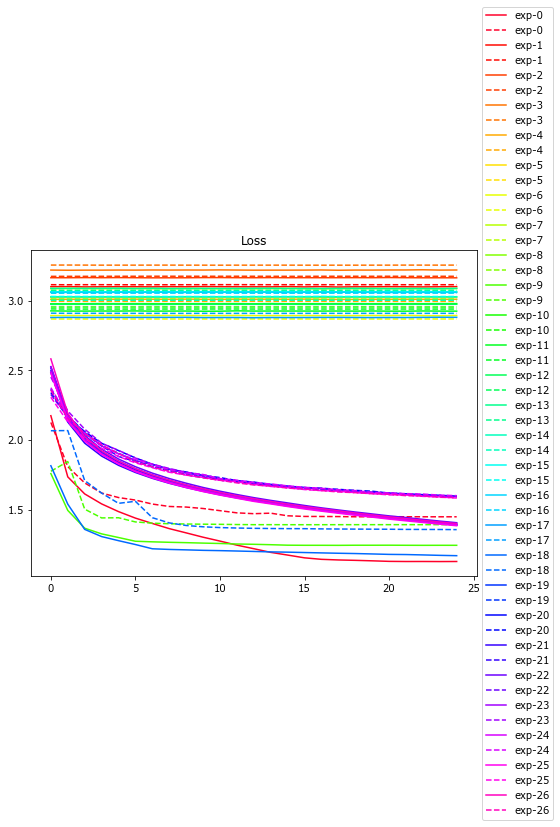

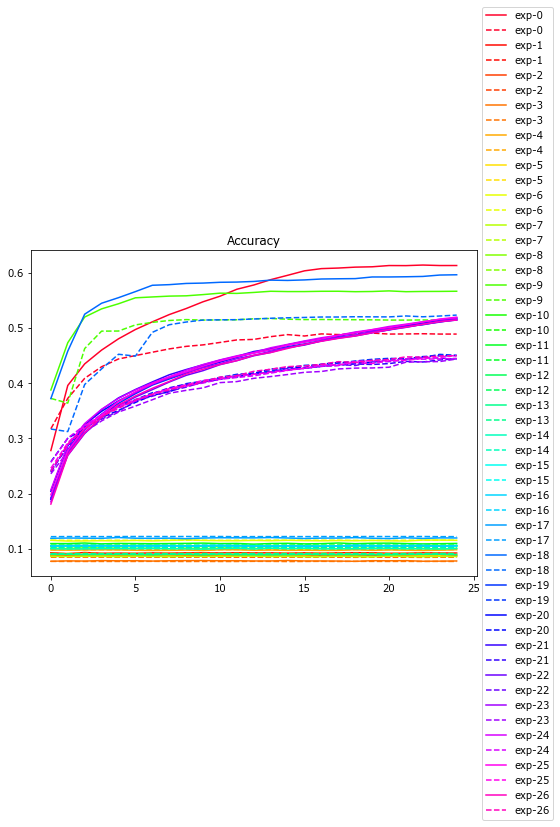

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()